# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Task Performed:
1. we need to work with 2 versions of KNN
a. brute force
b. kd tree
2. we suggest you not to go with GridsearchCV or k-fold as they take more time, use
Simple Cross validation dataset to find the best hyperparameters, and use the test
dataset report the final model performance
3. When we are working with the kd tree, we need to pass the dense matrix(constraint in
the sklearn library) So, when you are working on BOW and TFIDF we need to convert
these things into dense matrices.

    a. Using TruncatedSVD() this is exactly similar to PCA() and it can also accept
    sparse matrices and returns a dense matrix with lower dimensions
    i. Choosing the n_components we need to follow the elbow method

    b. Use max_features=2000(this can be changed according to your computing
    power) and min_df=50 (this can be changed according to your computing power)
    in Countvectorizer and then use .toarray() function to convert the sparse matrix to
    dense matrix.

4. Choose different metric other than accuracy for choosing the best hyperparameter,
which is apt for imbalanced datasets and accuracy sometimes gives us false conclusions
about the model performance sometimes.
5. For both of the algorithms, we can work with 10k(Due to less computing power because more data can cause the freezing state or hang your laptop if RAM is 4Gb) data points, Note that it will take more time you might need to wait.

In [1]:
import nltk
from nltk.stem import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
import sqlite3
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con = sqlite3.connect("./amazon-fine-food-reviews/database.sqlite")
data = pd.read_sql_query('''
SELECT *
FROM reviews
WHERE Score!=3
''', con)
data.shape

(525814, 10)

# Data cleaning

In [3]:
data['Score']  = data["Score"].apply(lambda x: 'positive' if x >= 4 else 'negative')
data.head(10)
print(data.shape)

(525814, 10)


In [4]:
data = data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print(data.shape)

(525812, 10)


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [5]:
sorted_data = data.sort_values('ProductId', inplace = False, axis =0, kind = 'quicksort', ascending = True, na_position = 'last')
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...


In [6]:
sorted_data['Text'].values

array([ "A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.",
       "This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.",
       'My daughter loves all the "Really Rosie" books. She was introduced to the Really Rosie CD performed by Carole King (also available on Amazon!) on her 1st Birthday and now, a year later, she knows all the songs. As far as the books go, we own: One Was Johnny, Alligators All Around, & Chicken Soup w/Rice. These books are well written with clever art work by Maurice Sendak. Plus, they are rea

In [7]:
filtered_data = sorted_data.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = False)
filtered_data.shape

(328770, 10)

In [8]:
filtered_data['Score'].value_counts()

positive    275650
negative     53120
Name: Score, dtype: int64

In [9]:
#text processing
final = filtered_data.copy()
#final = final.head(5000)

In [10]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [11]:
stop = set(stopwords.words("english"))
print(stop)

{'my', 'i', 'so', 'most', 'me', 'same', 'himself', 'out', 'will', 'further', 'your', 'here', 'was', 'these', 'm', 'ma', "hadn't", 'weren', "won't", 'y', 'am', 'didn', 'isn', 'as', 'against', 'an', 'some', 'by', 's', 'if', 'more', "mustn't", 'myself', 'up', 'had', 'that', 'and', 'which', "couldn't", 'those', 'they', 'during', 'have', 'now', 'mightn', "mightn't", 'to', 'both', 'when', 'because', 'there', 'being', 'but', 'his', "that'll", 'it', 'couldn', 'above', "don't", 'while', 'this', 'can', 'their', "didn't", 'shouldn', 'then', 'of', 'than', 'you', "you'd", 'her', 'them', 'nor', 'hasn', 'themselves', "she's", 'mustn', 'down', 'why', 'o', 'hers', 'how', 'own', 'under', "aren't", 'ours', 'once', 'in', 'don', 're', 'ain', 'who', "weren't", 'been', 'hadn', "wasn't", 'with', 'all', 'wasn', 'at', "shan't", 'he', 'are', "doesn't", "hasn't", 'very', 'be', 'whom', 'aren', 'below', "you've", 'our', 'into', 'does', 'or', 'doesn', "it's", "haven't", 'needn', 'did', 'after', 'only', 'such', 'too'

In [12]:
st = PorterStemmer()
st.stem('burned')

'burn'

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr,' ',sent)
    return cleaned
def cleanpunc(sent):
    clean = re.sub(r'[?|!|$|#|\'|"|:]',r'',sent)
    clean = re.sub(r'[,|(|)|.|\|/]',r' ',clean)
    return clean
                   

In [14]:
i=0
all_positive_reviews =[]
all_negative_reviews = []
final_string = []
stem_data = " "
for p in final['Text'].values:
    filtered_sens = []#filtered word
    p = cleanhtml(p)
    for w in p.split():
       # print(w)
        punc = cleanpunc(w)
        for s in punc.split():
            #print(w)
            if (s.isalpha()) & (len(s)>2):
                if s.lower() not in stop:
                    stem_data = (st.stem(s.lower())).encode('utf8')
                    #can we use lemmatizer and stemming altogether??
                    filtered_sens.append(stem_data)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(stem_data)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(stem_data)
                else:
                    continue
            else:
                continue
    #print(filtered_sens)
    str1 = b" ".join(filtered_sens)
    #print(str1)
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText'] = final_string
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",b'charm rhyme book describ circumst eat dont c...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",b'daughter love realli rosi book introduc real...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,b'summari young boy describ use chicken soup r...


In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


In [17]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = list(X[:10001])
y = final['Score'].values
y =list(y[:10001])
del X[2543]
del y[2543]

In [18]:
# from sklearn.model_selection import TimeSeriesSplit

In [19]:
# tscv = TimeSeriesSplit(n_splits = int((100000 - 30000)/30000))
# for train_index , test_index in tscv.split(X):
#     X_train,X_test = X[train_index],X[test_index]
#     y_train,y_test = y[train_index],y[test_index]

In [20]:
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y)

In [21]:
# X_test = X_test[:3000]
# y_test = y_test[:3000]

In [22]:
len(X_train)

8000

In [23]:
len(X_test)

2000

# KNN on BOW using brute and kd_tree algorithm

In [24]:
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_train)
bow_test = count_vect.transform(X_test)
#count_vect.get_feature_names()

In [25]:
# from scipy.sparse import csr_matrix
#bow_train = bow_train.todense()
#print(type(bow_train))

In [26]:
neighbors = list(np.arange(3,50,4))


In [27]:
#X_tr,X_test,y_tr,y_test = cross_validation.train_test_split(bow_X,bow_y,test_size=0.3,random_state= 42)
import warnings
warnings.filterwarnings("ignore")

cv_scores = []
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n,algorithm = 'brute')
    #knn = KNeighborsClassifier(n_neighbors = n,algorithm = 'kd_tree',leaf_size = 30)
    cross_val = cross_val_score(knn,bow_train,y_train,cv = 5 , scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
    
MSE = [1-x for x in cv_scores]
optimal_n = neighbors[ MSE.index(min(MSE)) ]
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_n,algorithm = 'brute')
knn_optimal.fit(bow_train,y_train)
pred = knn_optimal.predict(bow_test)
acc = accuracy_score(y_test,pred)*100

print("The accuracy for optimal k = {0} using brute is {1}".format(optimal_n,acc))
#print("The accuracy for optimal k = {0} using kd_tree is {1}".format(optimal_n,acc))

The accuracy for optimal k = 7 using brute is 88.85


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.70      0.03      0.06       227
   positive       0.89      1.00      0.94      1773

avg / total       0.87      0.89      0.84      2000



In [29]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
0.998307952623
0.0308370044053


PRECISION SCORE
0.889447236181
0.7


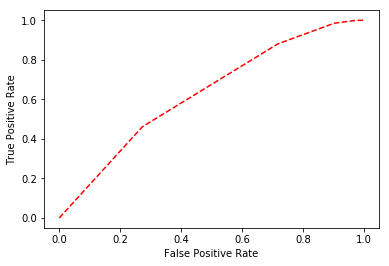

In [30]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = knn_optimal.predict_proba(bow_test)[:,1]
#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [31]:
print(roc_auc_score(y_true,y_pred))

0.630396972701


[[   7  220]
 [   3 1770]]


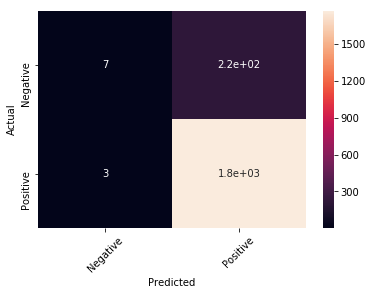

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# conclusion 

<h3>Brute Algo</h3>
1. Optimal K = 7.
2. Accuracy = 88.85
3. AUC = 0.6303(approx)
4. TN = 7
5. TP = 1770

In [33]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 200)
bow_tr = svd.fit_transform(bow_train)
bow_te = svd.transform(bow_test)
cv_scores = []
for n in neighbors:
    kn = KNeighborsClassifier(n_neighbors = n,algorithm = 'kd_tree',leaf_size = 30)
    cross_val = cross_val_score(kn,bow_tr,y_train,cv = 2 , scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
    
MSE = [1-x for x in cv_scores]
optima_n = neighbors[ MSE.index(min(MSE)) ]
knn_optima = KNeighborsClassifier(n_neighbors = optima_n, algorithm = 'kd_tree',leaf_size = 30)
knn_optima.fit(bow_tr,y_train)
pred = knn_optima.predict(bow_te)
ac = accuracy_score(y_test,pred)*100
print("The accuracy for optimal k = {0} using kd_tree is {1}".format(optima_n,ac))

The accuracy for optimal k = 23 using kd_tree is 88.75


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       1.00      0.01      0.02       227
   positive       0.89      1.00      0.94      1773

avg / total       0.90      0.89      0.84      2000



In [35]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
1.0
0.00881057268722


PRECISION SCORE
0.887387387387
1.0


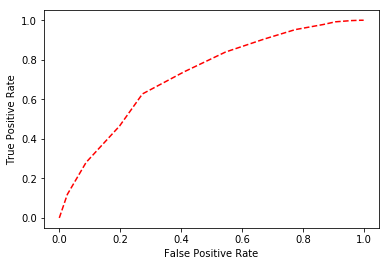

In [36]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = knn_optima.predict_proba(bow_te)[:,1]
#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [37]:
print(roc_auc_score(y_true,y_pred))

0.723115454281


[[   2  225]
 [   0 1773]]


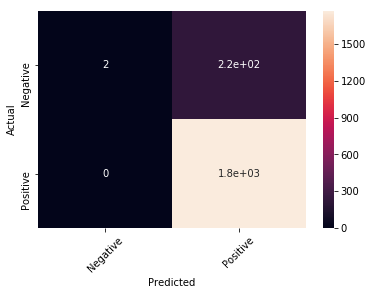

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# conclusion 

<h3>Kd-tree Algo</h3>
1. Optimal K = 23
2. Accuracy = 88.75
3. AUC = 0.723(approx)
4. TN = 2
5. TP = 1773

# KNN on TF-IDF using brute and kd_tree algorithms

In [39]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,4))
tfidf_train = tfidf_vect.fit_transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)

In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)
X_tr= sc.fit_transform(tfidf_train)
X_te = sc.transform(tfidf_test)

In [41]:
#X_train, X_tes,y_train,y_tes = cross_validation.train_test_split(tfidf_X,tfidf_y,test_size = 0.3 ,random_state = 42)
cv_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
    cross_val = cross_val_score(knn, X_tr,y_train,cv = 5 , scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
MSE_tfidf = [1-x for x in cv_scores]
optimal_i = neighbors[MSE_tfidf.index(min(MSE_tfidf))]
knn_tfidf = KNeighborsClassifier(n_neighbors = optimal_i,algorithm = 'brute')
knn_tfidf.fit(X_tr, y_train)
pred = knn_tfidf.predict(X_te)
acc_tfidf = accuracy_score(y_test, pred)*100
print("The accuracy for k = {0} using brute is {1}".format(optimal_i,acc_tfidf))

The accuracy for k = 3 using brute is 88.64999999999999


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       227
   positive       0.89      1.00      0.94      1773

avg / total       0.79      0.89      0.83      2000



In [43]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
1.0
0.0


PRECISION SCORE
0.8865
0.0


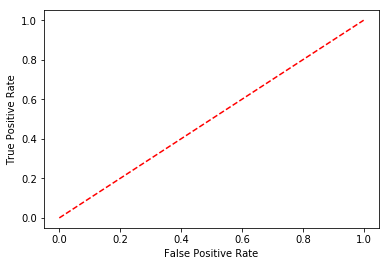

In [44]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = knn_tfidf.predict_proba(X_te)[:,1]
#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [45]:
print(roc_auc_score(y_true,y_pred))

0.500282007896


[[   0  227]
 [   0 1773]]


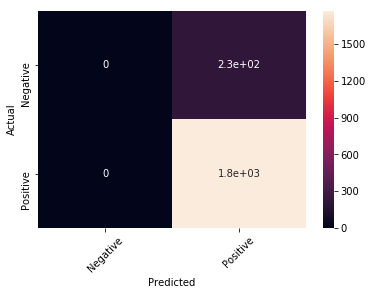

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# conclusion
<h3>Brute Algo</h3>
1. Optimal K = 3
2. Accuracy = 88.64
3. AUC = 0.5002(approx)
4. TN = 0
5. TP = 1773

In [47]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 200)
tfidf_tr = svd.fit_transform(X_tr)
tfidf_te = svd.transform(X_te)
cv_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'kd_tree',leaf_size = 35)
    cross_val = cross_val_score(knn, tfidf_tr,y_train,cv = 2 , scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
MSE_tfidf = [1-x for x in cv_scores]
optimal_i = neighbors[MSE_tfidf.index(min(MSE_tfidf))]
knn_tfidf = KNeighborsClassifier(n_neighbors = optimal_i,algorithm = 'kd_tree',leaf_size = 35,n_jobs = -1)
knn_tfidf.fit(tfidf_tr, y_train)
pred = knn_tfidf.predict(tfidf_te)
acc_tfidf = accuracy_score(y_test, pred)*100
print("The accuracy for k = {0} using Kd_tree is {1}".format(optimal_i,acc_tfidf))

The accuracy for k = 15 using Kd_tree is 88.64999999999999


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       227
   positive       0.89      1.00      0.94      1773

avg / total       0.79      0.89      0.83      2000



In [49]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
1.0
0.0


PRECISION SCORE
0.8865
0.0


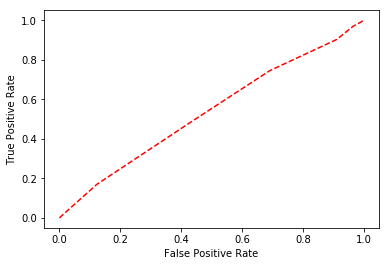

In [50]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = knn_tfidf.predict_proba(tfidf_te)[:,1]
#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [51]:
print(roc_auc_score(y_true,y_pred))

0.536774078132


[[   0  227]
 [   0 1773]]


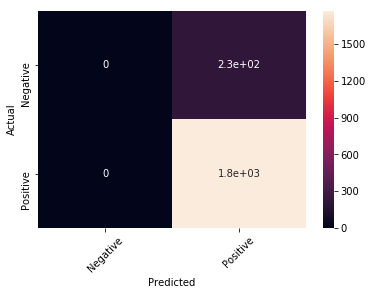

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# conclusion
<h3>Kd-tree Algo</h3>
1. Optimal K = 15
2. Accuracy = 88.65
3. AUC = 0.536(approx)
4. TN = 0
5. TP = 1773

# KNN on avg W2V using brute and kd_tree algorithm

In [53]:
list_of_sent_train = []
for i in X_train:
    sent=[]
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)
#list_of_sent_train[2543]

In [54]:
from gensim.models import Word2Vec
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)   
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            #print(vec)
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
#print((sent_vectors_train[2543]))
    

8000


In [55]:
list_of_sent_test = []
for i in X_test:
    sent=[]
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [56]:
from gensim.models import Word2Vec
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)   
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            #print(vec)
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
    

2000


In [57]:
cv_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
    cross_val = cross_val_score(knn, sent_vectors_train,y_train,cv = 5 , scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
MSE = [1-x for x in cv_scores]
optimal_i = neighbors[MSE.index(min(MSE))]
knn = KNeighborsClassifier(n_neighbors = optimal_i,algorithm = 'brute')
knn.fit(sent_vectors_train, y_train)
pred = knn.predict(sent_vectors_test)
acc = accuracy_score(y_test, pred)*100
print("The accuracy for k = {0} using brute is {1}".format(optimal_i,acc))

The accuracy for k = 43 using brute is 88.64999999999999


In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       227
   positive       0.89      1.00      0.94      1773

avg / total       0.79      0.89      0.83      2000



In [59]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
1.0
0.0


PRECISION SCORE
0.8865
0.0


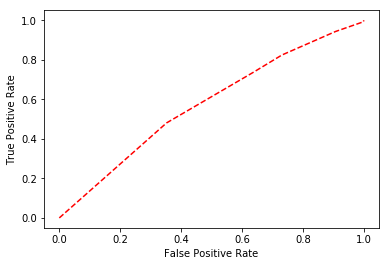

In [60]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = knn.predict_proba(sent_vectors_test)[:,1]

#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [61]:
print(roc_auc_score(y_true,y_pred))

0.576564522661


[[   0  227]
 [   0 1773]]


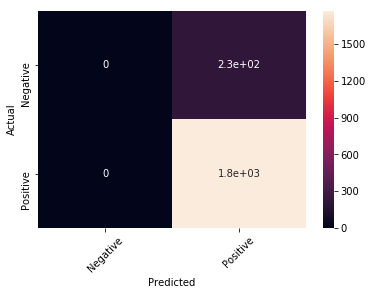

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# conclusion
<h3>Brute Algo</h3>
1. Optimal K = 43
2. Accuracy = 88.65
3. AUC = 0.576(approx)
4. TN = 0
5. TP = 1773

In [63]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 49)
sent_vectors_tr = svd.fit_transform(sent_vectors_train)
sent_vectors_te = svd.transform(sent_vectors_test)
cv_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'kd_tree')
    cross_val = cross_val_score(knn, sent_vectors_tr,y_train,cv = 10 , scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
MSE = [1-x for x in cv_scores]
optimal_i = neighbors[MSE.index(min(MSE))]
knn = KNeighborsClassifier(n_neighbors = optimal_i,algorithm = 'kd_tree')
knn.fit(sent_vectors_tr, y_train)
pred = knn.predict(sent_vectors_te)
acc = accuracy_score(y_test, pred)*100
print("The accuracy for k = {0} using Kd_tree is {1}".format(optimal_i,acc))

The accuracy for k = 47 using Kd_tree is 88.64999999999999


In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       227
   positive       0.89      1.00      0.94      1773

avg / total       0.79      0.89      0.83      2000



In [65]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
1.0
0.0


PRECISION SCORE
0.8865
0.0


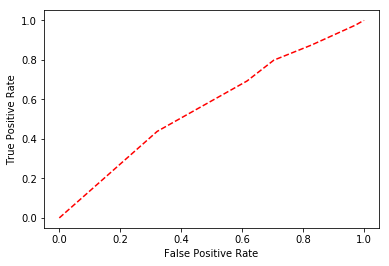

In [66]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = knn.predict_proba(sent_vectors_te)[:,1]
#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [67]:
print(roc_auc_score(y_true,y_pred))

0.566552621183


[[   0  227]
 [   0 1773]]


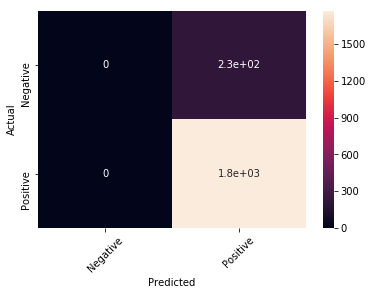

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# conclusion
<h3>Kd-tree Algo</h3>
1. Optimal K = 47
2. Accuracy = 88.649
3. AUC = 0.5665(approx)
4. TN = 0
5. TP = 1773

# KNN on tf-idf w2v using kd_tree and brute algorithm

In [69]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_train.append(sent_vec)
    row += 1
        
        

In [70]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1


In [93]:
np.where(np.isnan(tfidf_sent_vec_train))

(array([], dtype=int64), array([], dtype=int64))

In [92]:
del tfidf_sent_vec_train[7738]

In [94]:
del y_train[7738]

In [95]:
cv_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'brute')
    cross_val = cross_val_score(knn, tfidf_sent_vec_train,y_train,cv = 5 , scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
MSE = [1-x for x in cv_scores]
optimal_i = neighbors[MSE.index(min(MSE))]
knn = KNeighborsClassifier(n_neighbors = optimal_i,algorithm = 'brute')
knn.fit(tfidf_sent_vec_train, y_train)
pred = knn.predict(tfidf_sent_vec_test)
acc = accuracy_score(y_test, pred)*100
print("The accuracy for k = {0} using brute is {1}".format(optimal_i,acc))

The accuracy for k = 19 using brute is 88.64999999999999


In [96]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       227
   positive       0.89      1.00      0.94      1773

avg / total       0.79      0.89      0.83      2000



In [97]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
1.0
0.0


PRECISION SCORE
0.8865
0.0


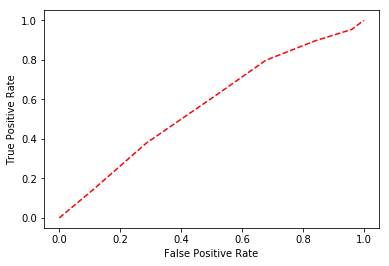

In [98]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = knn.predict_proba(tfidf_sent_vec_test)[:,1]
#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [99]:
print(roc_auc_score(y_true,y_pred))

0.570554151728


[[   0  227]
 [   0 1773]]


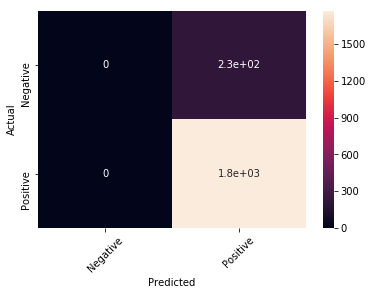

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# conclusion
<h3>Brute Algo</h3>
1. Optimal K = 19
2. Accuracy = 88.649
3. AUC = 0.5705(approx)
4. TN = 0
5. TP = 1773

In [101]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 49)
tfidf_sent_vec_tr = svd.fit_transform( tfidf_sent_vec_train)
tfidf_sent_vec_te = svd.transform( tfidf_sent_vec_test)
cv_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'kd_tree')
    cross_val = cross_val_score(knn,  tfidf_sent_vec_tr,y_train,cv = 5 , scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
MSE = [1-x for x in cv_scores]
optimal_i = neighbors[MSE.index(min(MSE))]
knn = KNeighborsClassifier(n_neighbors = optimal_i,algorithm = 'kd_tree')
knn.fit( tfidf_sent_vec_tr, y_train)
pred = knn.predict( tfidf_sent_vec_te)
acc = accuracy_score(y_test, pred)*100
print("The accuracy for k = {0} using Kd_tree is {1}".format(optimal_i,acc))

The accuracy for k = 15 using Kd_tree is 88.6


In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       227
   positive       0.89      1.00      0.94      1773

avg / total       0.79      0.89      0.83      2000



In [103]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
0.999435984208
0.0


PRECISION SCORE
0.886443221611
0.0


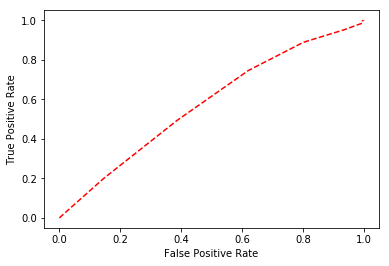

In [104]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = knn.predict_proba( tfidf_sent_vec_te)[:,1]
#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [105]:
print(roc_auc_score(y_true,y_pred))

0.576373204529


[[   0  227]
 [   1 1772]]


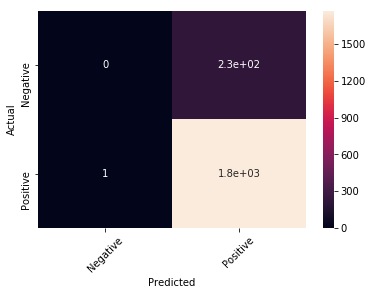

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# conclusion
<h3>kd-tree Algo</h3>
1. Optimal K = 15
2. Accuracy = 88.6
3. AUC = 0.5763(approx)
4. TN = 0
5. TP = 1772